# Prediction from densenet embeddings

Input: 
- csv with disease labels + embeddings extracted using the densenet torch x ray vision model  

Do:  
- train a neural network multiclass classifier to predict the diseases  
- assess bias  

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR



### Read the CSV

In [3]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("../model_dev/densenet_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test_initial.columns)
test_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [4]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [5]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [6]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

### Remove columns

In [7]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [8]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = test.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 0


### Convert age to binary to study bias

In [9]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Oversample data according to diseases

In [10]:
# diseases = ['Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumothorax']
# target_count = 20000

# # Function to upsample minority class
# def upsample_minority(df, disease, target_count):
#     # Filter the positive cases for the disease
#     disease_df = df[df[disease] == 1]
#     count_pos = disease_df.shape[0]
    
#     # Calculate the number of duplicates we need
#     n_duplicates = target_count - count_pos
    
#     if n_duplicates > 0:
#         # Randomly sample the positives rows to duplicate
#         duplicates = disease_df.sample(n=n_duplicates, replace=True)
#         # Append the duplicates to the original dataframe
#         df = pd.concat([df, duplicates])
        
#     return df


# for disease in diseases:
#     train = upsample_minority(train, disease, target_count)


### Create artificial training distribution

In [11]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

print("\nInitial Age Distribution:")
print(train['age'].value_counts())

print("\nInitial Health Distribution:")
print(train['insurance_type'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Initial Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Initial Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


In [12]:
nb_of_rows_to_remove = 0
cath_to_remove = 'sex' # sex or race
which_cath = 1 # 0 or 1 or 2

filtered_df = train[train[cath_to_remove] == which_cath]

rows_to_drop = filtered_df.sample(n=nb_of_rows_to_remove, random_state=42) 

train = train.drop(rows_to_drop.index)

print("\nFinal sex Distribution:")
print(train['sex'].value_counts())

print("\nFinal Race Distribution:")
print(train['race'].value_counts())

print("\nFinal Age Distribution:")
print(train['age'].value_counts())

print("\nFinal Health Distribution:")
print(train['insurance_type'].value_counts())


Final sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Final Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Final Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Final Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


### Visualize distribution of diseases

In [13]:
col = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No Finding']

print(f"Distribution in train set")
for disease in col:
    counts = train[disease].value_counts()
    print(f"{disease}: - 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")
print(f"Distribution in test set")
for disease in col:
    counts = test[disease].value_counts()
    print(f"{disease}:- 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")


Distribution in train set
Enlarged Cardiomediastinum: - 0s: 63738, 1s: 3458
Cardiomegaly: - 0s: 58986, 1s: 8210
Lung Opacity: - 0s: 33926, 1s: 33270
Lung Lesion: - 0s: 64703, 1s: 2493
Edema: - 0s: 51202, 1s: 15994
Consolidation: - 0s: 62851, 1s: 4345
Pneumonia: - 0s: 65571, 1s: 1625
Atelectasis: - 0s: 57067, 1s: 10129
Pneumothorax: - 0s: 60688, 1s: 6508
Pleural Effusion: - 0s: 40484, 1s: 26712
Pleural Other: - 0s: 66251, 1s: 945
Fracture: - 0s: 64485, 1s: 2711
No Finding: - 0s: 61107, 1s: 6089
Distribution in test set
Enlarged Cardiomediastinum:- 0s: 38350, 1s: 1957
Cardiomegaly:- 0s: 35347, 1s: 4960
Lung Opacity:- 0s: 20463, 1s: 19844
Lung Lesion:- 0s: 38810, 1s: 1497
Edema:- 0s: 30622, 1s: 9685
Consolidation:- 0s: 37814, 1s: 2493
Pneumonia:- 0s: 39325, 1s: 982
Atelectasis:- 0s: 34107, 1s: 6200
Pneumothorax:- 0s: 36201, 1s: 4106
Pleural Effusion:- 0s: 24418, 1s: 15889
Pleural Other:- 0s: 39739, 1s: 568
Fracture:- 0s: 38699, 1s: 1608
No Finding:- 0s: 36645, 1s: 3662


### Train evaluate test

In [14]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cmottez (cmottez-stanford-university). Use `wandb login --relogin` to force relogin


True

In [15]:
# Initialize a new run
wandb.init(project='test_bias', entity='cmottez-stanford-university')

In [16]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

In [172]:


# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            #  'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Lung Opacity', 'Pleural Effusion']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

In [173]:
# learning_rate = 0.001
# weight_decay = 1e-1
# dropout = 0.2
# batch_size = 256

learning_rate = 0.0005
weight_decay = 0
dropout = 0.5
batch_size = 128

In [174]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


In [175]:

# Assuming y_train is a tensor of shape (num_samples, num_classes)
# where each element is 0 or 1 indicating the absence or presence of a class

def calculate_sample_weights(y_train):
    # Calculate the frequency of each class
    class_counts = y_train.sum(axis=0)
    print(class_counts)
    # Compute the weight for each class (inverse frequency, normalized)
    class_weights = 1. / (class_counts + 1e-5)  # Add a small value to avoid division by zero
    class_weights /= class_weights.sum()  # Normalize so that sum of weights is 1
    print(class_weights)
    
    # Compute the sample weights
    sample_weights = torch.mm(y_train, class_weights.unsqueeze(1)).squeeze()
    
    return sample_weights

sample_weights = calculate_sample_weights(y_train)

# Convert sample weights to a Sampler compatible format
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create DataLoader using the WeightedRandomSampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)


tensor([ 8210., 33270., 15994., 10129.,  6508., 26712.], device='cuda:0')
tensor([0.2416, 0.0596, 0.1240, 0.1958, 0.3048, 0.0742], device='cuda:0')


In [176]:
# # Define the neural network
# class MultiLabelNN(nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MultiLabelNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout) 

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x


In [177]:

# # Define the simplified neural network
# class MultiLabelNN(nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MultiLabelNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
#         self.fc2 = nn.Linear(256, 128)  # Second hidden layer
#         self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
#         self.relu = nn.ReLU()  # ReLU activation function
#         self.dropout = nn.Dropout(dropout)  # Dropout for regularization

#     def forward(self, x):
#         x = self.fc1(x)  # First linear transformation
#         x = self.relu(x)  # Activation function
#         x = self.dropout(x)  # Apply dropout
#         x = self.fc2(x)  # Second linear transformation
#         x = self.relu(x)  # Activation function
#         x = self.dropout(x)  # Apply dropout
#         x = self.fc3(x)  # Final linear transformation to output size
#         return x


In [178]:

# Define a more complex neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(MultiLabelNN, self).__init__()
        # Increase the complexity by adding more layers and a wider network
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(128, output_size)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [179]:

# # Define the linear model
# class MultiLabelNN(nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MultiLabelNN, self).__init__()
#         self.fc = nn.Linear(input_size, output_size)  # Only one linear layer

#     def forward(self, x):
#         x = self.fc(x)  # Direct linear transformation
#         return x



In [180]:
# Calculate weights inversely proportional to class frequencies
class_counts = y_train.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.mean()  # Normalizing


# Example to increase the weight of positive examples in loss calculation
pos_weights = torch.ones([len(diseases)]).to(device)  # one weight per class
pos_weights *= 5  # Increasing the weights for positive examples

# Use these weights in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


In [181]:
model = MultiLabelNN(1024, len(diseases), dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [182]:
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=1) 

In [183]:
def train_model(train_loader, validation_loader, model, criterion, optimizer, scheduler, num_epochs, patience=3):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(validation_loader)
        training_stats['val_loss'].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # reset counter if validation loss improves
        else:
            patience_counter += 1
            print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print('Stopping early due to no improvement in validation loss.')
                break

        # Update the learning rate
        scheduler.step()

    return training_stats


In [184]:
# # Training the model with loss reporting and improved visualization
# def train_model(train_loader, validation_loader, model, criterion, optimizer, num_epochs):
#     model.train()
#     training_stats = {'train_loss': [], 'val_loss': []}

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss, total_val_loss = 0, 0

#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         training_stats['train_loss'].append(total_loss / len(train_loader))

#         # Validation loss calculation
#         model.eval()
#         with torch.no_grad():
#             for data, target in validation_loader:
#                 data, target = data.to(device), target.to(device)
#                 output = model(data)
#                 val_loss = criterion(output, target)
#                 total_val_loss += val_loss.item()

#         training_stats['val_loss'].append(total_val_loss / len(validation_loader))
#         print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

#         wandb.log({
#         'epoch': epoch,
#         'training_loss': loss,
#         'validation_loss': val_loss,
#     })

#     return training_stats


Epoch 1/20, Training Loss: 0.5429, Validation Loss: 0.4593
Epoch 2/20, Training Loss: 0.5228, Validation Loss: 0.4484
Epoch 3/20, Training Loss: 0.5194, Validation Loss: 0.4409
Epoch 4/20, Training Loss: 0.5166, Validation Loss: 0.4426
Validation loss did not improve. Patience: 1/3
Epoch 5/20, Training Loss: 0.5136, Validation Loss: 0.4398
Epoch 6/20, Training Loss: 0.5112, Validation Loss: 0.4369
Epoch 7/20, Training Loss: 0.5082, Validation Loss: 0.4351
Epoch 8/20, Training Loss: 0.5079, Validation Loss: 0.4431
Validation loss did not improve. Patience: 1/3
Epoch 9/20, Training Loss: 0.5059, Validation Loss: 0.4361
Validation loss did not improve. Patience: 2/3
Epoch 10/20, Training Loss: 0.5028, Validation Loss: 0.4381
Validation loss did not improve. Patience: 3/3
Stopping early due to no improvement in validation loss.


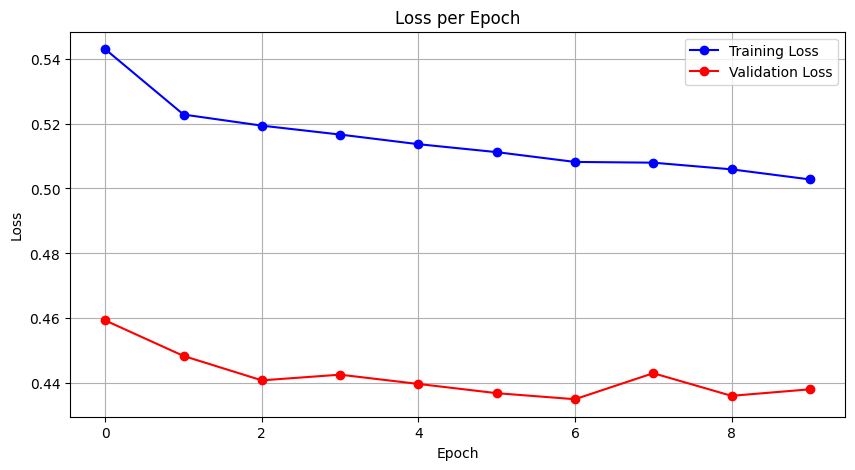

In [185]:
# Run training
nb_epoch = 20
stats = train_model(train_loader, valid_loader, model, criterion, optimizer, scheduler, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [186]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

In [187]:
# Evaluate on test data
predictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



In [188]:
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            # 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No finding']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Lung Opacity', 'Pleural Effusion']


In [189]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.8190140670355025, 'AUC': 0.8143237363530417, 'AUPRC': 0.41489733866677514, 'F1 Score': 0.44528933160976353, 'TP Rate': 0.5903225806451613, 'FN Rate': 0.4096774193548387, 'TN Rate': 0.8511047613658868, 'FP Rate': 0.14889523863411322}, 'Lung Opacity': {'Accuracy': 0.5173543057037239, 'AUC': 0.6917373930379286, 'AUPRC': 0.6429191167445494, 'F1 Score': 0.06290944123314066, 'TP Rate': 0.03290667204192703, 'FN Rate': 0.967093327958073, 'TN Rate': 0.987147534574598, 'FP Rate': 0.012852465425401945}, 'Edema': {'Accuracy': 0.7723968541444414, 'AUC': 0.7908296264740879, 'AUPRC': 0.5117552163477561, 'F1 Score': 0.48379473328831873, 'TP Rate': 0.44388229220443987, 'FN Rate': 0.5561177077955601, 'TN Rate': 0.876298086343152, 'FP Rate': 0.12370191365684802}, 'Atelectasis': {'Accuracy': 0.7903838043019823, 'AUC': 0.60069214578031, 'AUPRC': 0.20210567429015114, 'F1 Score': 0.18296102891403154, 'TP Rate': 0.15258064516129033, 'FN Rate': 0.8474193548387097, 'TN Rate': 0.9

In [190]:
auc_dict = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUC':
            auc_dict[disease] = value

auprc = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUPRC':
            auprc[disease] = value

auprc

{'Cardiomegaly': 0.41489733866677514,
 'Lung Opacity': 0.6429191167445494,
 'Edema': 0.5117552163477561,
 'Atelectasis': 0.20210567429015114,
 'Pneumothorax': 0.2631843594120289,
 'Pleural Effusion': 0.7181894994761525}

### Parameters finetuning

In [191]:
learning_rates = [0.001, 0.005, 0.01]
weight_decays = [0, 1e-3, 1e-5]
dropouts = [0, 0.2, 0.5, 0.8]
batch_sizes = [32, 64, 128, 256]

# learning_rates = [0.001, 0.005]
# weight_decays = [0, 1e-3]
# dropouts = [0, 0.2, 0.5]
# batch_sizes = [32, 65, 128]

In [192]:

def try_parameters(learning_rate, weight_decay, dropout, batch_size, nb_epoch, test_valid = "valid"): 

    diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']


    # train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    model = MultiLabelNN(1024, len(diseases), dropout).to(device)
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    stats = train_model(train_loader, valid_loader, model, criterion, optimizer, nb_epoch)

    # Evaluate on valid data or on test data if not trying to fine the best parameters but just want to evaluate the predictions
    if test_valid == "test":
        predictions, targets = evaluate_model(test_loader)
    else:
        predictions, targets = evaluate_model(valid_loader)

    
    # Create the no finding column
    updated_predictions = []

    for row in predictions:
        # Check if all elements in the row are less than or equal to 0.5
        if np.all(row <= 0.5):
            new_row = np.append(row, 1)
        else:
            new_row = np.append(row, 0)
        updated_predictions.append(new_row)

    predictions = np.array(updated_predictions)

    updated_targets = []
    for target, no_finding_target in zip(targets, y_no_finding):
        new_target = np.append(target, no_finding_target)
        updated_targets.append(new_target)

    targets = np.array(updated_targets)

    metrics = compute_metrics(predictions, targets)

    auprc_dict = {}

    for disease, values in metrics.items():
        for metric, value in values.items():
            if metric == 'AUPRC':
                auprc_dict[disease] = value

    return stats, auprc_dict


def plot_loss(stats):
    plt.figure(figsize=(5, 3))
    plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [193]:
best_param = {'learning_rate': 0,
              'weight_decay': 0,
              'dropout': 0,
              'batch_size': 0}
previous_aupcr = 0

In [194]:

# for learning_rate in learning_rates:
#     # print(f"Results for learning_rate = {learning_rate}")
#     for weight_decay in weight_decays:
#         # print(f"Results for weight_decay = {weight_decay}")
#         for dropout in dropouts:
#             # print(f"Results for dropout = {dropout}")
#             for batch_size in batch_sizes:
#                 print(f"Results for learning_rate = {learning_rate}, weight_decay = {weight_decay}, dropout = {dropout} batch_size = {batch_size}")
#                 stats, aupcr = try_parameters(learning_rate, weight_decay, dropout, batch_size, 5, "test")
#                 print(f"AUPCR {aupcr}")
#                 mean_aupcr = sum(aupcr.values()) / len(aupcr)
#                 if mean_aupcr > previous_aupcr:
#                     previous_aupcr = mean_aupcr
#                     best_aupcr = aupcr
#                     best_param['learning_rate'] = learning_rate
#                     best_param['weight_decay'] = weight_decay
#                     best_param['dropout'] = dropout
#                     best_param['batch_size'] = batch_size
                    
#                 # plot_loss(stats)
# print(f'best_param: {best_param}')
# print(f"best_aupcr: {best_aupcr}")

In [195]:
# stats, aupcr_dict = best_param, best_aupcr

In [196]:
# stats

In [197]:
# aupcr_dict

In [198]:
# stats, aupcr_dict = try_parameters(0.001, 0, 0.5, 32, 5, test_valid = "test")
# plot_loss(stats)
# aupcr_dict

In [199]:
# metrics['Atelectasis']

### Compute metrics for different categories

In [200]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [201]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,41.490,81.432,81.769,80.872,0.897,3.000
1,Lung Opacity,64.292,69.174,69.011,69.377,0.365,0.395
2,Edema,51.176,79.083,79.406,78.640,0.766,1.837
3,Atelectasis,20.211,60.069,60.711,59.105,1.606,0.741
4,Pneumothorax,26.318,74.743,74.039,75.735,1.696,1.028
5,Pleural Effusion,71.819,81.808,81.532,82.228,0.696,3.213


In [202]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,41.490,81.432,81.051,82.430,81.345,1.379,9.465
1,Lung Opacity,64.292,69.174,68.828,71.155,69.937,2.327,0.782
2,Edema,51.176,79.083,79.136,77.993,79.286,1.293,3.950
3,Atelectasis,20.211,60.069,60.310,56.698,59.559,3.612,3.782
4,Pneumothorax,26.318,74.743,74.072,78.358,76.431,4.285,5.038
5,Pleural Effusion,71.819,81.808,81.593,81.513,82.827,1.314,3.202


In [203]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,41.490,81.432,78.170,82.936,4.765,3.982
1,Lung Opacity,64.292,69.174,65.529,70.850,5.321,0.382
2,Edema,51.176,79.083,77.067,79.947,2.880,5.199
3,Atelectasis,20.211,60.069,58.576,60.902,2.327,3.745
4,Pneumothorax,26.318,74.743,74.727,74.077,0.650,8.005
5,Pleural Effusion,71.819,81.808,81.320,81.977,0.657,5.531


In [204]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,41.490,81.432,82.601,80.516,82.164,2.085,6.044
1,Lung Opacity,64.292,69.174,71.802,67.288,71.907,4.619,0.471
2,Edema,51.176,79.083,77.696,78.068,81.195,3.499,4.853
3,Atelectasis,20.211,60.069,60.204,59.504,61.387,1.884,2.326
4,Pneumothorax,26.318,74.743,74.839,74.552,73.694,1.145,11.015
5,Pleural Effusion,71.819,81.808,82.599,81.221,82.536,1.378,4.762


In [205]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,41.490,81.432,0.897,3.000,1.379,9.465,4.765,3.982,2.085,6.044
1,Lung Opacity,64.292,69.174,0.365,0.395,2.327,0.782,5.321,0.382,4.619,0.471
2,Edema,51.176,79.083,0.766,1.837,1.293,3.950,2.880,5.199,3.499,4.853
3,Atelectasis,20.211,60.069,1.606,0.741,3.612,3.782,2.327,3.745,1.884,2.326
4,Pneumothorax,26.318,74.743,1.696,1.028,4.285,5.038,0.650,8.005,1.145,11.015
5,Pleural Effusion,71.819,81.808,0.696,3.213,1.314,3.202,0.657,5.531,1.378,4.762


In [206]:
df.to_csv("nn_big_initial_bias.csv")

### Study a specific metric and compare

In [207]:
met = 'AUPRC'  #Accuracy, AUC, F1 Score, TP Rate, FN Rate

In [208]:
# Compute metrics for each disease
auc_general = {}
for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == met:
            auc_general[disease] = value

print(f"General {met}", auc_general)


General AUPRC {'Cardiomegaly': 0.41489733866677514, 'Lung Opacity': 0.6429191167445494, 'Edema': 0.5117552163477561, 'Atelectasis': 0.20210567429015114, 'Pneumothorax': 0.2631843594120289, 'Pleural Effusion': 0.7181894994761525}


In [209]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

for disease, values in metrics_female.items():
    for metric, value in values.items():
        if metric == met:
            auc_female[disease] = value

for disease, values in metrics_male.items():
    for metric, value in values.items():
        if metric == met:
            auc_male[disease] = value

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


AUPRC for Females: {'Cardiomegaly': 0.38583582322312054, 'Lung Opacity': 0.6431775289578352, 'Edema': 0.5190683274011227, 'Atelectasis': 0.18656591753873425, 'Pneumothorax': 0.2590275026038633, 'Pleural Effusion': 0.7256698279045546}
AUPRC for Males: {'Cardiomegaly': 0.4333677139746152, 'Lung Opacity': 0.6427344210915694, 'Edema': 0.507258318742875, 'Atelectasis': 0.21452508695013878, 'Pneumothorax': 0.26608980705241925, 'Pleural Effusion': 0.7132366460262645}


In [210]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

for disease, values in metrics_white.items():
    for metric, value in values.items():
        if metric == met:
            auc_white[disease] = value

for disease, values in metrics_asian.items():
    for metric, value in values.items():
        if metric == met:
            auc_asian[disease] = value

for disease, values in metrics_black.items():
    for metric, value in values.items():
        if metric == met:
            auc_black[disease] = value

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


AUPRC for W: {'Cardiomegaly': 0.3874046174898723, 'Lung Opacity': 0.6412243084694422, 'Edema': 0.5151582674493271, 'Atelectasis': 0.20818614984382192, 'Pneumothorax': 0.2548662061618587, 'Pleural Effusion': 0.7184428224683566}
AUPRC for B: {'Cardiomegaly': 0.5605467393966953, 'Lung Opacity': 0.6398853685741451, 'Edema': 0.5429850676603931, 'Atelectasis': 0.16195851481543858, 'Pneumothorax': 0.22510450458827783, 'Pleural Effusion': 0.6567164606703463}
AUPRC for A: {'Cardiomegaly': 0.4365194176330249, 'Lung Opacity': 0.6528395852189735, 'Edema': 0.47231735430135696, 'Atelectasis': 0.18433809358422704, 'Pneumothorax': 0.3208944064552428, 'Pleural Effusion': 0.7404382108674983}


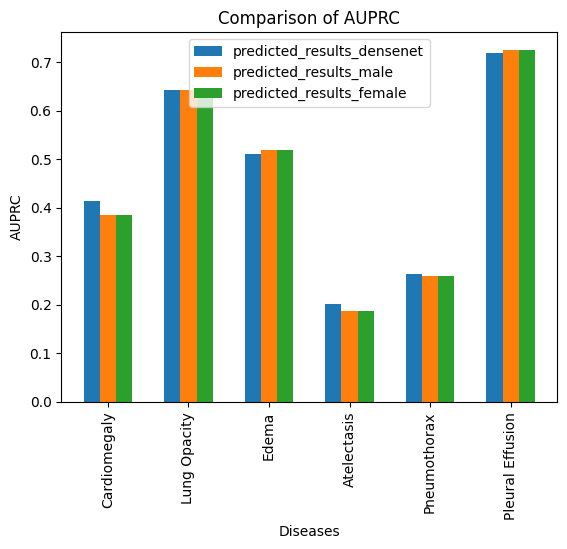

In [211]:

# Extract diseases and AUC values
diseases_to_plot = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases_to_plot]
values_male = [auc_female[disease] for disease in diseases_to_plot]
values_female = [auc_female[disease] for disease in diseases_to_plot]

# Setting the positions and width for the bars
positions = np.arange(len(diseases_to_plot))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


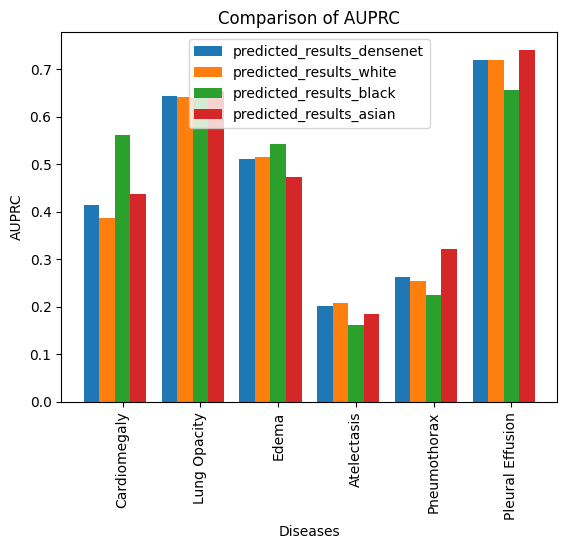

In [212]:

# Extract diseases and AUC values
diseases = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
